In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import random
import pandas as pd

%matplotlib inline

In [2]:
def step_coords(dimensions, steps=1):
    '''
    Returns coordinates of steps.
    '''
    coords = []
    for seed in range(dimensions):

        if not coords:
            coords = [[step] for step in range(-steps, steps+1)]

        else:
            new_coord = []
            for coord in coords:
                for step in range(-steps, steps+1):
                    new_coord.append(coord+[step])
                    
            coords = new_coord

    return coords

def get_sqerror(Y, func, X, **kwargs):
    '''
    Returns squared errors of parameters
    '''
    return sum([(y - func(x, **kwargs))**2 for x, y in zip(X, Y)])

In [3]:

def fit_line(param_names, Y, func, X,
             seeds=None, incr=1e-3, diff=1e-5, max_iter=25e3):
    '''
    Fits parameters according to function f
    '''
    if not seeds:
        seeds = [0 for p in param_names]

    param_vals = seeds
    params = {k:v for k, v in zip(param_names, param_vals)}

    err = get_sqerror(Y, func, X, **params)
    prev_err = err

    r_int = int(-np.log10(min(incr, diff)))

    progress = [{'params':params, 'error':err}]

    incr_steps = [[incr*x for x in coord] for coord in step_coords(len(param_names))]

    i = 0

    while True:

        tests = []
        for incr_step in incr_steps:
            # test step
            test_vals = [v+s for v, s in zip(param_vals, incr_step)]
            test_params = {k:v for k, v in zip(param_names, test_vals)}
            test_err = get_sqerror(Y, func, X, **test_params)

            tests.append( # add to tests
                {
                    'param_vals': test_vals,
                    'params' : test_params,
                    'err' : test_err
                }
            )

        for test in tests:
            if test['err'] < err: # update if improvement
                param_vals, params, err = test['param_vals'], test['params'], test['err']

        if prev_err-err < diff:
            print(f'Search ended: error improvement less than {diff} with {incr} increment')
            break

        progress.append({'params':params, 'error':err})
        prev_err = err
        i+=1
        
        if i > max_iter: #max_iter reached
            print(f'{max_iter} max iterations reached.')
            break

    print(f'Sq Error: {round(err, r_int)} | Improvement: {round(prev_err-err, r_int)}')
    print(f'{i} iterations')
    
    return {'result' : params, 'progress' : progress}

Trial [0]
Search ended: error improvement less than 1e-05 with 0.001 increment
Sq Error: 0.0102 | Improvement: 0.0
11010 iterations


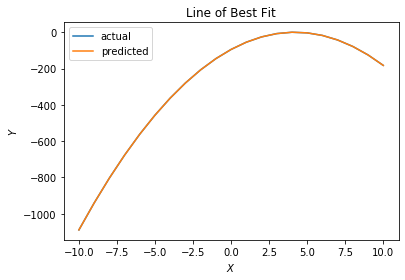

Actual     | a:-5.418 b:4.188 c:1.029
Predicted  | a:-5.417 b:4.188 c:1.010


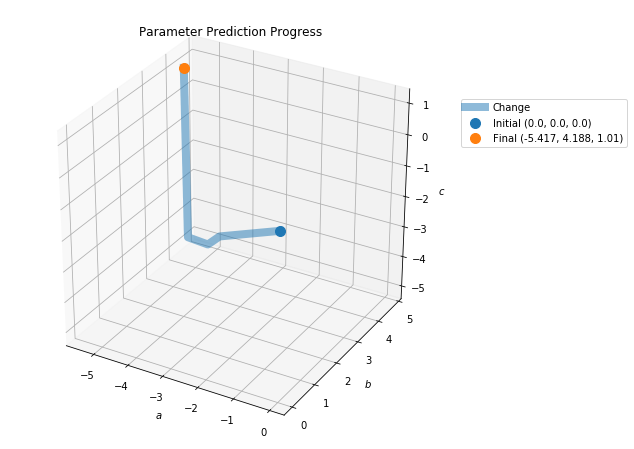

In [8]:
def f(x, a, b, c):
    return a*(x-b)**2 + c


X = [i for i in range(-10, 11)]


for i in range(1):
    
    param_names = tuple('abc')
    actual_params = {p : random.gauss(0, 10) for p in param_names}
    actual = [f(x, **actual_params) for x in X]

    print(('='*20)+f'\nTrial [{i}]')

    # fit line
    fit = fit_line(param_names, Y=actual, func=f, X=X)

    pred_params = fit['result']

    # predicted 
    predicted = [f(x, **pred_params) for x in X]

    # plot
    fig, ax0 = plt.subplots()

    ax0.plot(X, actual, label='actual')
    ax0.plot(X, predicted, label='predicted')

    ax0.legend()
    ax0.set_xlabel('$X$')
    ax0.set_ylabel('$Y$')
    ax0.set_title('Line of Best Fit')
    plt.show()

    act_msg = ' '.join([f'{k}:{v:.3f}' for k, v in actual_params.items()])
    pred_msg = ' '.join([f'{k}:{v:.3f}' for k, v in pred_params.items()])
    print(f'Actual     |', act_msg)
    print(f'Predicted  |', pred_msg)
    
    
    # plot progress
    df = pd.DataFrame([d['params'] for d in fit['progress']])
    data = [list(df[col]) for col in df.columns]
    
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    seed = tuple(round(p[0],3) for p in data)
    final = tuple(round(p[-1],3) for p in data)
    
    ax1.plot(*data, alpha=0.5, label='Change', lw=8)
    ax1.scatter(*seed, s=100, label=f'Initial {seed}')
    ax1.scatter(*final, s=100,label=f'Final {final}')
    
    ax1.set_title('Parameter Prediction Progress')
    ax1.set_xlabel(f'${param_names[0]}$')
    ax1.set_ylabel(f'${param_names[1]}$')
    ax1.set_zlabel(f'${param_names[2]}$')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.4, .8))
    
    plt.show()